![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 4. Techniki estymowania modeli w próbach niezbalansowanych

### Spis treści:

1. Wprowadzenie.
2. Klasyczny oversampling/undersampling.
3. NearMiss/Tomek links.
4. Synthetic sampling SMOTE/ROSE.
5. Modele z modyfikowalną funkcją celu (Cost-Sensitive Training).

# 1. Wprowadzenie

W zadaniach klasyfikacyjnych zmienna objaśniana rzadko ma równy rozkład pomiędzy kategoriami. W przypadku kiedy dysproporcja między klasami jest silna (np. klasa mniejszościowa ma mniej niż 5%-10% udziałów może to być problematyczne. Zbiory takie nazywamy niezbalansowanymi (z ang. *imbalanced dataset*, rzadziej *unbalanced dataset*). Większość funkcji straty jest oparta o minimalizację błędu dopasowania (którą odzwierciedla metryka Accuracy), przez co model może skupić się na klasie większościowej (w końcu z perspektywy funkcji straty bardziej się to opłaca). Bardzo trudno jest wtedy wykrywać klasę mniejszościową, która najczęściej jest celem modelowania, mogą to być:

* fraudy na kartach kredytowych,
* niechciane wiadomości (spam),
* rzadkie schorzenia,
* predykcja awarii maszyny,
* konwersje klientów z kampanii reklamowych w Internecie,
* churn klientów (w niektórych usługach, np. z odnawialną subskrypcją).

W takiej sytuacji należy podejść do modelowania ze szczególną starannością:

1. Wyniki modelowania powinny zostać przeanalizowane za pomocą różnych metryk i dla różnych cut-off.
2. W przypadku niesatysfakcjonujących wyników sprawdzić wpływ specjalistycznych metod próbkowania danych.
3. Wykorzystać algorytmy które lepiej sprawdzają się w takich przypadkach (np. algorytmy oparte o drzewa decyzyjne), 
4. Zmodyfikować funkcje straty, zwiększając koszty pomyłki w klasie mniejszościowej (można skorzystac w tym celu z modeli, które mają wbudowany interfejs do modyfikacji wag w funkcji straty).

W praktyce zaawansowane algorytmy (jak xgboost) radzą sobie przyzwoicie w próbach niezbalansowanych i sampling nie jest niezbędny.

## 1.1 Metryki w problemach klasyfikacyjnych

### 1.1.1 Miary dyskretne
Tymczasem w problemie klasyfikacji trudniej jest nam bezpośrednio obejrzeć błąd oszacowania, szczególnie kiedy przez predykcje rozumiemy wytypowane wartości dyskretne. W takiej sytuacji pierwszą miarą, która przychodzi nam na myśl jest dokładność (ang. *accuracy*). Zobaczmy jak w praktyce mogą wyglądać nasze predykcje.

<center>
<img src="img/confMatrix2.png" width="45%">
    </center>
Źródło: http://www.ritchieng.com/machine-learning-evaluate-classification-model/

Oznaczenia:
$TP$ - true positive, $TN$ - True negatives, $FP$ - False postives, $FN$ - False negatives, $P$ - number of positives, $N$ - number of negatives

* Acc - Accuracy - Dokładność
$$ Acc = {(TP+TN) \over (P+N)}$$

Jak łatwo się domyślić nie jest to najlepsza miara. O ile w przypadku prób zbalansowanych jej wyniki można interpretować intuicyjnie, to przy próbach niezbalansowanych już nie. W przypadku,  w którym w naszym zbiorze jest 99 jedynek i jedno zero uzyskamy dokładność na poziomie 99% nawet jeżeli każdej obserwacji przypiszemy jedynkę. Miara dokładności jest więc zupełnie nieznormalizowana. Czemu na przeciw wychodzi zbalansowana dokładność.

* Bacc - Balanced Accuracy
$$ Bacc = ({TP \over P} + {TN \over N})/2$$

Kiedy spojrzymy na zera i jedynki osobno to łącznie uzyskamy już całkiem przejrzysty obraz. Obydwie miary mogą osiągnąć wartości od 0 do 1. Kiedy jedna z nich jest wysoka a druga niska od razu domyślamy się, że mamy problem z niezbalansowaną próbą.

* TPR - True Positive Rate - Sensitivity, Hit Rate, Recall - Wrażliwość
$$ TPR = {TP \over P} = {TP \over TP+FN}$$


* TNR (SPC) - True Negative Rate, Specificity - Specyficzność
$$TNR = {TN \over N} = {TN \over FP+TN}$$


Analogicznie naszym mianownikiem może stanowić łączna liczba predykcji dla danej grupy, a nie łączna liczba wartości w danej grupie jak powyżej.

* PPV - Positive Predictive Value, Precision - Precyzja
$$ PPV = {TP \over TP + FP}$$

* NPV - Negative Predictive Value 
$$ NPV = {TN \over TN+FN}$$

Możemy też czasem spotkać :
* F1 - f-score
$$F_1 = {2 \over {1 \over precision} + {1 \over recall}} = 2 * {(precision * recall) \over (precision + recall)}$$

Dobre podsumowanie miar przedstawia poniższy rysunek:
<center>
<img src="img/measuresMatrix.png" width="55%">
    </center>
Źródło: https://en.wikipedia.org/wiki/Confusion_matrix

### 1.1.2 Metryki dla prawdopodobieństw

Kiedy analizujemy nasze predykcje jedynie z perspektywy przewidywanych poziomów zupełnie tracimy pewną bardzo istotną informację. Mianowicie to, jakie prawdopodobieństwo nasz algorytm przypisał danej obserwacji. Chyba wszystkie algorytmy klasyfikacji operując na funkcjach ciągłych przypisują prawdopodobieństwa pomiędzy 0 a 1. Dopiero w ostatnim kroku wybieramy poziom odcięcia, który pozwala nam zdecydować do której z kategorii powinniśmy przypisać daną obserwację. Dla jednej "1" przewidywane prawdopodobieństwo mogło wynieść 0.55, a dla innej 0.93. Można potocznie powiedzieć, że w drugim przypadku nasz algorytm był bardziej "pewny". Tymczasem operując na etykietach tracimy tę informację.

**ROC - Receiver Operating Characteristic Curve** - krzywa ROC pozwala nam zobaczyć jak zmieniają się nasze wartości TPR i FPR (FPR = 1 - TNR) wraz ze wzrostem progu odcięcia. Jest to prawdopodobnie najwygodniejsze narzędzie do oceny jakości modeli w problemie klasyfikacji binarnej.

<center>
<img src="img/roc.png" width="35%">
    </center>
Źródło: http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

Jak widać, krzywa zawsze będzie przebiegać pomiędzy lewym dolnym rogiem kwadratu (TPR=0 i FPR=0) a prawym górnym (TPR=1 i FPR=1). Jednocześnie im lepszy model tym bliższy będzie jej przebieg do lewego górnego rogu (szybszy wzrost TPR przy jak najwolniejszym wzroście FPR). Początkowo dla progu odcięcia bliskiego 1 klasyfikujemy wszystkie wartości jako 0. Uzyskujemy oczywiście TNR = 1 (FPR  = 0). Wraz ze wzrostem progu odcięcia zwiększamy szansę na to, że pojawią się w naszych prognozach "1". Część z tych jedynek dobrze trafimy dzięki czemu TPR zaczyna rosnąć. Nasz klasyfikator najprawdopodobniej nie będzie idealny, więc część "1" powstanie niesłusznie, przez co rosnąć zacznie FPR (a TNR spadać). **Idealny klasyfikator będzie przebiegał zatem po krawędziach kwadratu przechodząc przez lewy górny róg.**

**AUC ROC - Area Under Curve.** Pole pod krzywą zwykle dotyczy krzywej ROC. Ta zmienna to całka pod krzywą, która przyjmuje wartości wartości od 0,5 (brak potencjału prognostycznego, losowy klasyfikator) do 1 (doskonały klasyfikator). W sytuacji w której chcemy opisać jakość modelu jedną liczbą jest to prawdopodobnie najlepsza miara dla klasyfikacji binarnej.

AUC można interpretować jako prawdopodobieństwo, że losowo wybrany element klasy pozytywnej otrzyma wyższą wartość score niż losowo wybrany element klasy negatywnej. AUC wykorzystujemy, żeby pokazać jak dobrze model sortuje prawdopodobieństwa, nie jest użyteczne jeśli zależy nam na kalibracji prawdopodobieństw.

**Precision/recall curve - AUC PR.** Inną miarą, która w ostatnich czasach zyskuje na popularności jest Average precision, czy też Precision/recall curve. Z jednej strony jest ona podobna/analogiczna do ROC. Korzystamy bowiem z tych samych punktów (uporzadkowanych prawdopodobieństw), jednak zamiast patrzeć na TPR i TNR , patrzymy na TPR (Recall) i PPV (Precision).

<center>
<img src="img/precRecallCurve.png" width="35%">
</center>
Źródło: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Krzywa precision-recall analizuje trade-off między PPV a TPR. Sprawdza zatem, jak spada czystość sygnału jak obniżamy cut-off. Zatem sprawdzamy, jaki jest koszt obniżenia jakości sygnału, kiedy chcemy wychwycić więcej TP. Dla krzywej można policzyć **PR AUC Score**, którą można interpretować jako przeciętną wartość precision dla cut-off <0, 1>.

Właściwości krzywej Precision-recall:

* łatwiej się intepretuje biznesowo niż ROC (łatwiej wybrać adekwatny biznesowo cut-off),
* bardziej niż ROC nadaje się do danych silnie niezbalansowanowanych,
* przydatna gdy bardziej interesuje nas Positive class, niż Negative Class.

Źródła: 
* Davis, J., & Goadrich, M. (2006, June). The relationship between Precision-Recall and ROC curves. In Proceedings of the 23rd international conference on Machine learning (pp. 233-240). ACM.
* https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a#9891![image.png](attachment:image.png)

## 1.2 Pakiety

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

# Prepocessing
from sklearn import preprocessing

# import metod do walidacji krzyżowej
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.svm import SVC

# Sampling
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Wrappery xgboost
from helpers_xgb import run_xgb

# Wrapper do rysowania krzywej ROC
from helpers2 import plotROCandPRs

In [2]:
# Centrowanie obrazków
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1.3 Przygotowanie danych

In [3]:
# dfs=[]

# for i in range(6):
#     print(f'creditcard{i}')
#     with open(f'data/creditcard{i}.p', 'rb') as fp:
#         dfs.append(pickle.load(fp))
        
# df=pd.concat(dfs, axis=0)
# df.head()

(284807, 31)
0    284315
1       492
Name: Class, dtype: int64


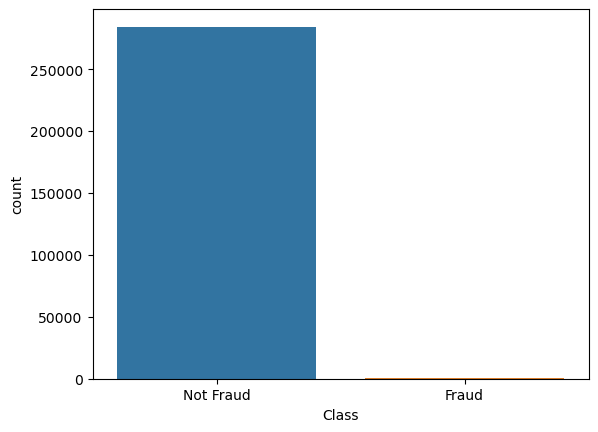

In [4]:
df = pd.read_csv('data/creditcard.csv.zip')
print(df.shape)
df.head()

print(df['Class'].value_counts())

fig, ax = plt.subplots()
sn.countplot(x = 'Class', data = df, ax = ax)
ax.set_xticklabels(['Not Fraud','Fraud'])

features = df.columns.tolist()
features.remove('Class')
target = 'Class'

## 1.4 Estymacja modelu referencyjnego

In [5]:
def CVTestXGB(nFolds = 5, randomState=2020, features=None, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1

    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [6]:
# (model estymuje się kilka minut)
trainResults, testResults, predictions, indices, hists = CVTestXGB(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1)
np.mean(trainResults), np.mean(testResults)

(0.9363664209503538, 0.9332808187643742)

In [7]:
modelXGB = {
    "name":"XGB base",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [8]:
with open("XGB.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB, fp)

In [9]:
with open("XGB.p", "rb") as fp:
    modelXGB = pickle.load(fp)

In [10]:
true = df[target].sort_index().rename('Observed', axis=0)

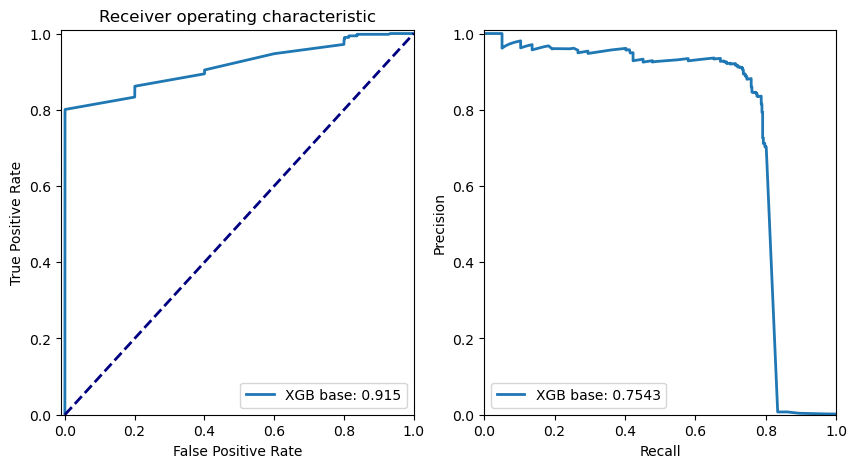

In [11]:
res2plot = []

for result in [modelXGB]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))

plotROCandPRs(res2plot)

Przyjrzyjmy się rozkładowi prawdopodobieństw:

Predicted                                                        
             count    mean     std     min     25%     50%     75%     max
Observed                                                                  
0.0       284315.0  0.2992  0.1527  0.0004  0.3373  0.3476  0.3806  0.9687
1.0          492.0  0.5591  0.1856  0.0004  0.4687  0.5455  0.6017  0.9879

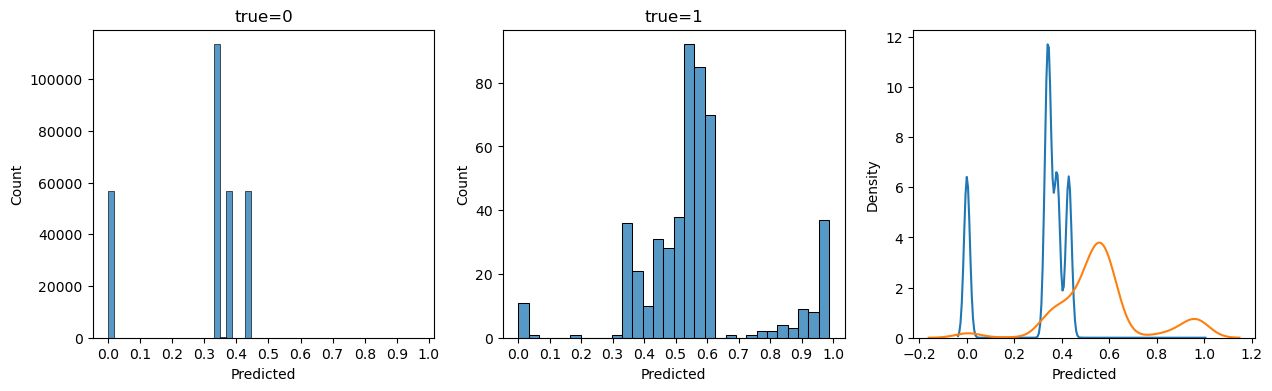

In [12]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe().round(4))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

sn.histplot(pred[true==0], bins = 50, ax=ax[0])
ax[0].set_xticks(np.arange(0, 11)/10)
ax[0].set_title('true=0')
sn.histplot(pred[true==1], ax=ax[1])
ax[1].set_xticks(np.arange(0, 11)/10)
ax[1].set_title('true=1')

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted", ax=ax[2])
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted", ax=ax[2]);

Przeanalizujmy wyniki z punktu widzenia kilku potencjalnie optymalnych punktów cutoff: 

In [13]:
def summarise_model(true, pred, ths = np.arange(0, 101, 1)/100):

    acc = []
    prec = []
    rec = []
    f1 = []
    yJ = []

    for th in ths:
        predY = pred.apply(lambda x: 1 if x > th else 0)
        acc.append(metrics.accuracy_score(true, predY))
        prec.append(metrics.precision_score(true, predY, zero_division=0))
        rec.append(metrics.recall_score(true, predY))
        f1.append(metrics.f1_score(true, predY))
        yJ.append(metrics.recall_score(true, predY, pos_label=1) + metrics.recall_score(true, predY, pos_label=0)-1)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    axes=axes.flatten()

    #Accuracy 
    opt=ths[acc.index(max(acc))]
    axes[0].plot(ths, acc, label = f'Acc: {round(max(acc), 3)}, {round(opt, 3)}')
    axes[0].axvline(x = opt, color = 'm', linestyle = '--', linewidth=2)
    axes[0].legend()
    axes[0].set_xlabel('cutoff')
    axes[0].set_ylabel('Accuracy')

    # Precision
    opt=ths[prec.index(max(prec))]
    axes[1].plot(ths, prec, label = f'Prec: {round(max(prec), 3)}, {round(opt, 3)}')
    axes[1].axvline(x = opt, color = 'y', linestyle = '--', linewidth=2)
    axes[1].legend(loc='upper right')
    axes[1].set_xlabel('cutoff')
    axes[1].set_ylabel('Precision')

    # Recall v. Precision
    th_rec = max([i for i, x, y in zip(ths, rec, prec) if x>y])
    th_prec = min([i for i, x, y in zip(ths, rec, prec) if x<=y])
    th_eq = (th_rec + th_prec)/2    
    
    axes[2].plot(ths, prec, label = 'Precision')
    axes[2].plot(ths, rec, label = 'Recall')
    axes[2].axvline(x = th_eq, color = 'r', linestyle = '--', linewidth=2)
    axes[2].set_title(f'Precision:{round(prec[np.where(ths == th_prec)[0][0]], 3)}; Recall: {round(rec[np.where(ths == th_rec)[0][0]], 3)}; cutoff: {round(th_eq, 3)}', fontsize=10)
    axes[2].set_xlabel('cutoff')
    axes[2].set_ylabel('Precision/Recall')

    # F1
    opt=ths[f1.index(max(f1))]
    axes[3].plot(ths, f1, label = f'F1: {round(max(f1), 3)}, {round(opt, 3)}')
    axes[3].axvline(x = opt, color = 'c', linestyle = '--', linewidth=2)
    axes[3].legend(loc='upper right')
    axes[3].set_xlabel('cutoff')
    axes[3].set_ylabel('F1')

    # Youden J
    opt=ths[yJ.index(max(yJ))]
    axes[4].plot(ths, yJ, label = f'YJ: {round(max(yJ), 3)}, {round(opt, 3)}')
    axes[4].axvline(x = opt, color = 'g', linestyle = '--', linewidth=2)
    axes[4].legend()
    axes[4].set_xlabel('cutoff')
    axes[4].set_ylabel('Youden J')

    # Summary
    axes[5].plot(ths, acc)
    axes[5].axvline(x = ths[acc.index(max(acc))], c='m', linestyle = '--', linewidth=1.5, label = f'Acc: {round(ths[acc.index(max(acc))], 3)}')
    axes[5].axvline(x = ths[prec.index(max(prec))], c='y', linestyle = '--', linewidth=1.5, label = f'Prec: {round(ths[prec.index(max(prec))], 3)}')
    axes[5].axvline(x = th_eq, c='r', linestyle = '--', linewidth=1.5, label = f'Rec/Prec: {round(th_eq, 3)}')
    axes[5].axvline(x = ths[f1.index(max(f1))], c='c', linestyle = '--', linewidth=1.5, label = f'F1 score: {round(ths[f1.index(max(f1))], 3)}')
    axes[5].axvline(x = ths[yJ.index(max(yJ))], c='g', linestyle = '--', linewidth=1.5, label = f'YJ: {round(ths[yJ.index(max(yJ))], 3)}')
    axes[5].legend()
    axes[5].set_xlabel('cutoff')
    axes[5].set_ylabel('Statistics')

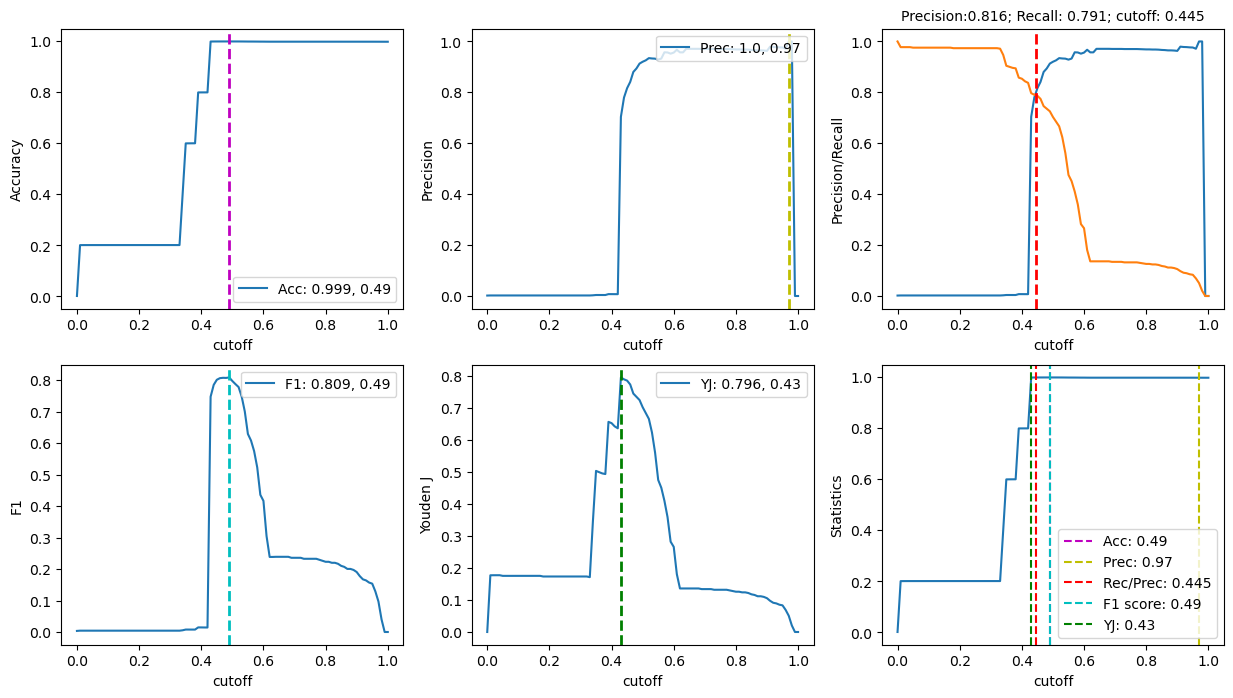

In [14]:
summarise_model(true, pred)

Wykonaj tabele krzyżowe dla niektórych cutoff (znowu skorzystamy z wrappera):

In [15]:
def crosstable(pred, cutoff):
    predClass = pred.apply(lambda x: 1 if x > cutoff else 0).rename('Predicted')

    print('Accuracy:', round(metrics.accuracy_score(true, predClass),4))
    print('Sensitivity:', round(metrics.recall_score(true, predClass),4))
    print('Precision:', round(metrics.precision_score(true, predClass),4))
    print('F1:', round(metrics.f1_score(true, predClass),4))

    return pd.crosstab(true, predClass).iloc[::-1, ::-1]

In [16]:
crosstable(pred, .5)

Accuracy: 0.9994
Sensitivity: 0.7033
Precision: 0.9202
F1: 0.7972


Predicted,1,0
Observed,,
1,346,146
0,30,284285


In [17]:
crosstable(pred, .49)

Accuracy: 0.9994
Sensitivity: 0.7256
Precision: 0.913
F1: 0.8086


Predicted,1,0
Observed,,
1,357,135
0,34,284281


In [18]:
crosstable(pred, .445)

Accuracy: 0.9993
Sensitivity: 0.7886
Precision: 0.7967
F1: 0.7926


Predicted,1,0
Observed,,
1,388,104
0,99,284216


Ciekawy wariant poniżej:

In [19]:
crosstable(pred, .43)

Accuracy: 0.9991
Sensitivity: 0.7967
Precision: 0.7038
F1: 0.7474


Predicted,1,0
Observed,,
1,392,100
0,165,284150


Ale już dalsze schodzenie z cutoff nieopłacalne:

In [20]:
crosstable(pred, .42)

Accuracy: 0.7998
Sensitivity: 0.8374
Precision: 0.0072
F1: 0.0142


Predicted,1,0
Observed,,
1,412,80
0,56944,227371


In [21]:
crosstable(pred, .429)

Accuracy: 0.7998
Sensitivity: 0.8333
Precision: 0.0071
F1: 0.0142


Predicted,1,0
Observed,,
1,410,82
0,56935,227380


## 1.5 Tuning hiperparametru `scale_pos_weight`

Według dokumentacji efektywna wartość tego parametru jest równy stosunkowi liczności klasy większościowej i mniejszościowej: 

In [22]:
df[target].value_counts()[0]/df[target].value_counts()[1]

577.8760162601626

In [23]:
# (model estymuje się kilka minut)
trainResults, testResults, predictions, indices, hists = CVTestXGB(features=features, scale_pos_weight=578,
                                                                   max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1)
np.mean(trainResults), np.mean(testResults)

(0.9998559436617798, 0.9859798769224201)

In [24]:
modelXGB_spw = {
    "name":"XGB spw=578",
    "description":"Model XGB z scale_pos_weight=578",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [25]:
with open("XGB_spw.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB_spw, fp)

In [26]:
with open("XGB_spw.p", "rb") as fp:
    modelXGB_spw = pickle.load(fp)

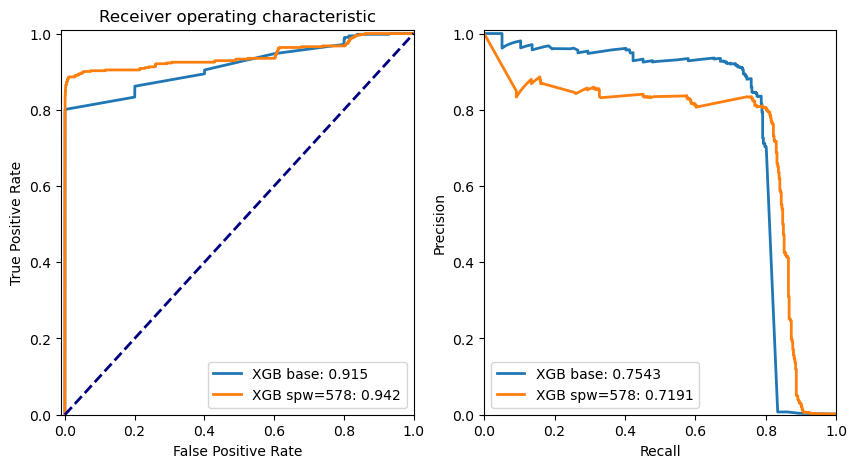

In [27]:
res2plot = []

for result in [modelXGB, modelXGB_spw]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))

plotROCandPRs(res2plot)

# 2. Undersampling/Oversampling

Jedną z prostszych metod poprawy właściwości modelu jest poprawa właściwości próby uczącej przez wyrównanie (niekoniecznie całkowite) liczebności kategorii. Aby to osiągnąć, można albo odlosować obserwacje z klasy większościowej (undersampling) albo poprzez bootstrap (lub w bardziej skomplikowany sposób, co omówimy później) dolosować obserwacje z klasy mniejszościowej. W pierwszym przypadku wadą jest utrata informacji, w drugim jest to ryzyko przetrenowania modelu i spowolnienie kalkulacji (spowodowane zwiększeniem próby uczącej). 

<img src="img/sampling1.png" width="60%">
Źródło: https://www.svds.com/learning-imbalanced-classes/

W literaturze można znaleźć wytyczne dotyczące stosowania samplingu:

* undersampling powinien być używany kiedy mamy 10000+ obserwacji (oversampling w przeciwnym przypadku)
* należy spróbować losowego jak i stratyfikowanego samplingu – żeby kluczowe zmienne były reprezentatywne w podpróbce
* jeżeli masz mało obserwacji, albo chcesz mieć mniej „spreparowane” wyniki możesz spróbować samplingu w proporcji innej niż 1:1
* sampling należy robić osobno w każdej iteracji walidacji krzyżowej – żeby uniknąć przetrenowania.
* sampling należy zrobić na zbiorze uczącym, a następnie na walidacyjnym sprawdzić jak model zachowuje się na rzeczywistych rozkładach.
* generalnie oversampling wydaje się lepszym rozwiazaniem niż undersampling


Dodatkowo, w pracy Wallace et al., Class Imbalance, Redux (2011) prezentują ciekawą technikę, zwaną blaggingiem.

<img src="img/sampling2.png" width="80%">
Źródło: https://www.svds.com/learning-imbalanced-classes/, Wallace et al., Class Imbalance, Redux (2011)

## 2.1 Undersampling

In [28]:
def CVTestXGB_under(nFolds = 5, randomState=2020, features=None, sampling_strategy='auto', debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    
    # Przygotowanie obiektu do undersamplingu
    rus = RandomUnderSampler(random_state=42, replacement=True, sampling_strategy=sampling_strategy)

    for train, test in kf.split(df.index.values):
        # Under sampling zbioru treningowego 
        x_rus, y_rus = rus.fit_resample(df.iloc[train][features], df.iloc[train][target])
        df_rus = pd.concat([x_rus, y_rus], axis=1)
        
        # Wydruk rozkładu zmiennej objaśnianej w pierwszym foldzie
        if fold==1:
            print(y_rus.value_counts())
        
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_rus, df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df_rus[target], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [29]:
trainResults, testResults, predictions, indices, hists = CVTestXGB_under(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

0    399
1    399
Name: Class, dtype: int64


(0.9956329554773398, 0.9825372235185619)

In [30]:
modelXGB_under = {
    "name":"XGB under",
    "description":"Model XGB z pełnym undersamplingiem",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [31]:
with open("XGB_under.p", "wb") as fp:
    pickle.dump(modelXGB_under, fp)

In [32]:
with open("XGB_under.p", "rb") as fp:
    modelXGB_under = pickle.load(fp)

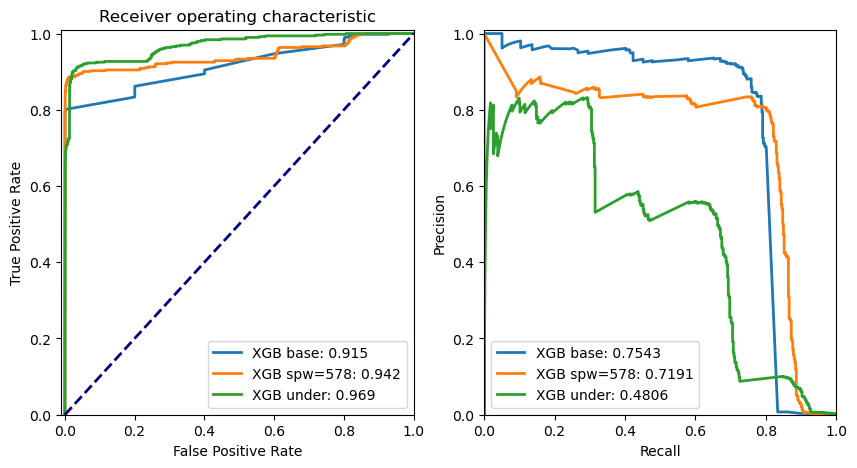

In [33]:
res2plot = []

for result in [modelXGB, modelXGB_spw, modelXGB_under]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

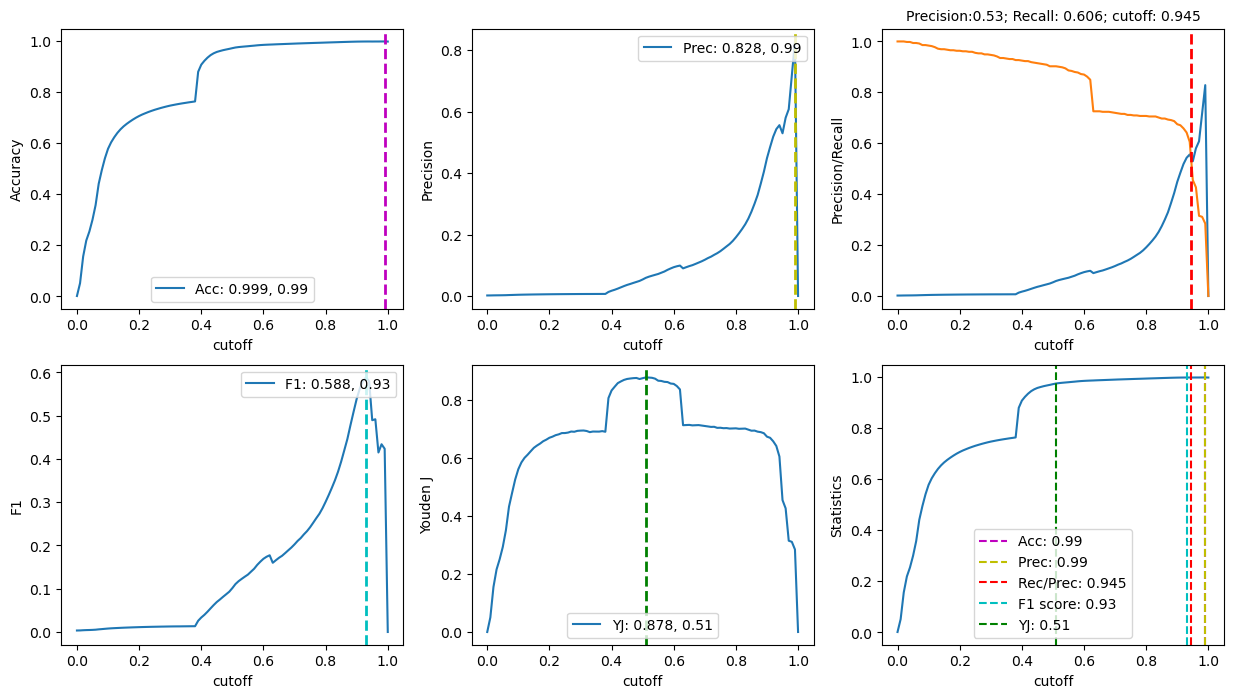

In [34]:
summarise_model(true, pred)

In [35]:
crosstable(pred, 0.51)

Accuracy: 0.975
Sensitivity: 0.9024
Precision: 0.059
F1: 0.1108


Predicted,1,0
Observed,,
1,444,48
0,7078,277237


In [36]:
crosstable(pred, 0.93)

Accuracy: 0.9984
Sensitivity: 0.6423
Precision: 0.543
F1: 0.5885


Predicted,1,0
Observed,,
1,316,176
0,266,284049


Predicted                                                        
             count    mean     std     min     25%     50%     75%     max
Observed                                                                  
0.0       284315.0  0.1617  0.1682  0.0023  0.0389  0.0813  0.3120  0.9983
1.0          492.0  0.8286  0.2365  0.0255  0.6243  0.9429  0.9914  0.9983

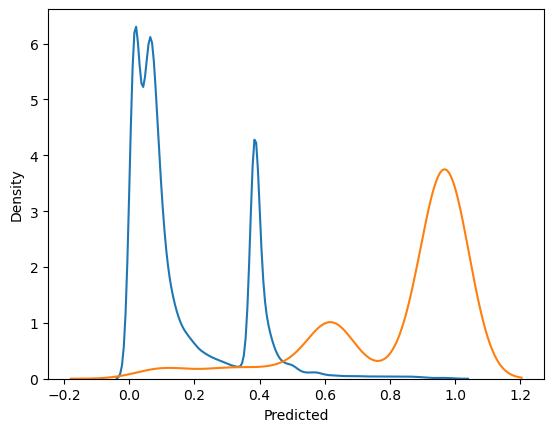

In [37]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe().round(4))

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted")
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted");

In [38]:
trainResults, testResults, predictions, indices, hists = CVTestXGB_under(features=features, sampling_strategy=.1,
                                                                         max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

0    3990
1     399
Name: Class, dtype: int64


(0.9891903220038687, 0.9789385098905423)

Spróbujmy przeliczyć jeszcze inne warianty undersamplingu:

In [39]:
modelXGB_under1 = {
    "name":"XGB under .1",
    "description":"Model XGB z undersamplingiem minority=0.1",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [40]:
with open("XGB_under1.p", "wb") as fp:
    pickle.dump(modelXGB_under1, fp)

In [41]:
with open("XGB_under1.p", "rb") as fp:
    modelXGB_under1 = pickle.load(fp)

In [42]:
modelXGB_under01 = {
    "name":"XGB under .01",
    "description":"Model XGB z undersamplingiem minority=0.01",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [43]:
with open("XGB_under01.p", "wb") as fp:
    pickle.dump(modelXGB_under01, fp)

In [44]:
with open("XGB_under01.p", "rb") as fp:
    modelXGB_under01 = pickle.load(fp)

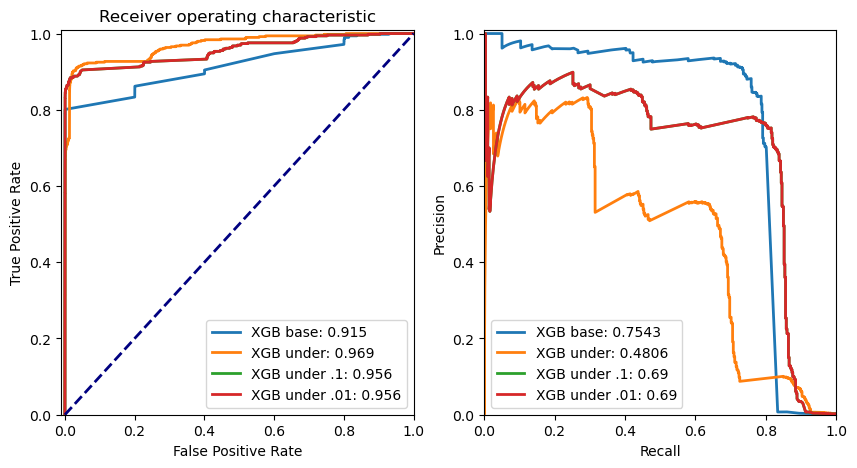

In [45]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelXGB_under1, modelXGB_under01]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

## 2.2 Oversampling

In [46]:
def CVTestXGB_over(nFolds = 5, randomState=2020, sampling_strategy='auto', shrinkage=None, features=None, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    
    # Przygotowanie obiektu do oversamplingu
    ros = RandomOverSampler(random_state=42, sampling_strategy=sampling_strategy, shrinkage=shrinkage)

    for train, test in kf.split(df.index.values):
        # Under sampling zbioru treningowego 
        x_ros, y_ros = ros.fit_resample(df.iloc[train][features], df.iloc[train][target])
        df_ros = pd.concat([x_ros, y_ros], axis=1)
        
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_ros, df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df_ros[target], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [47]:
# procedura trwa kilka minut
trainResults, testResults, predictions, indices, hists = CVTestXGB_over(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

(0.9997994982092134, 0.9846166741138415)

In [48]:
modelXGB_over = {
    "name":"XGB over",
    "description":"Model XGB z oversamplingiem",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [49]:
with open("XGB_over.p", "wb") as fp:
    pickle.dump(modelXGB_over, fp)

In [50]:
with open("XGB_over.p", "rb") as fp:
    modelXGB_over = pickle.load(fp)

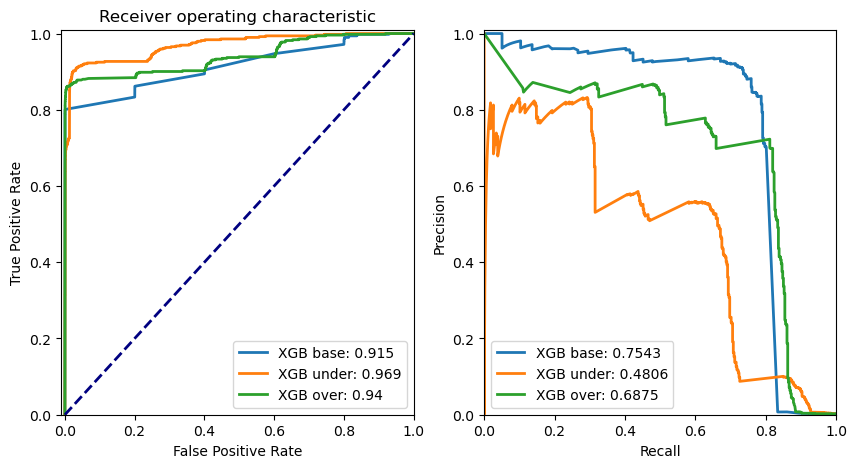

In [51]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelXGB_over]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

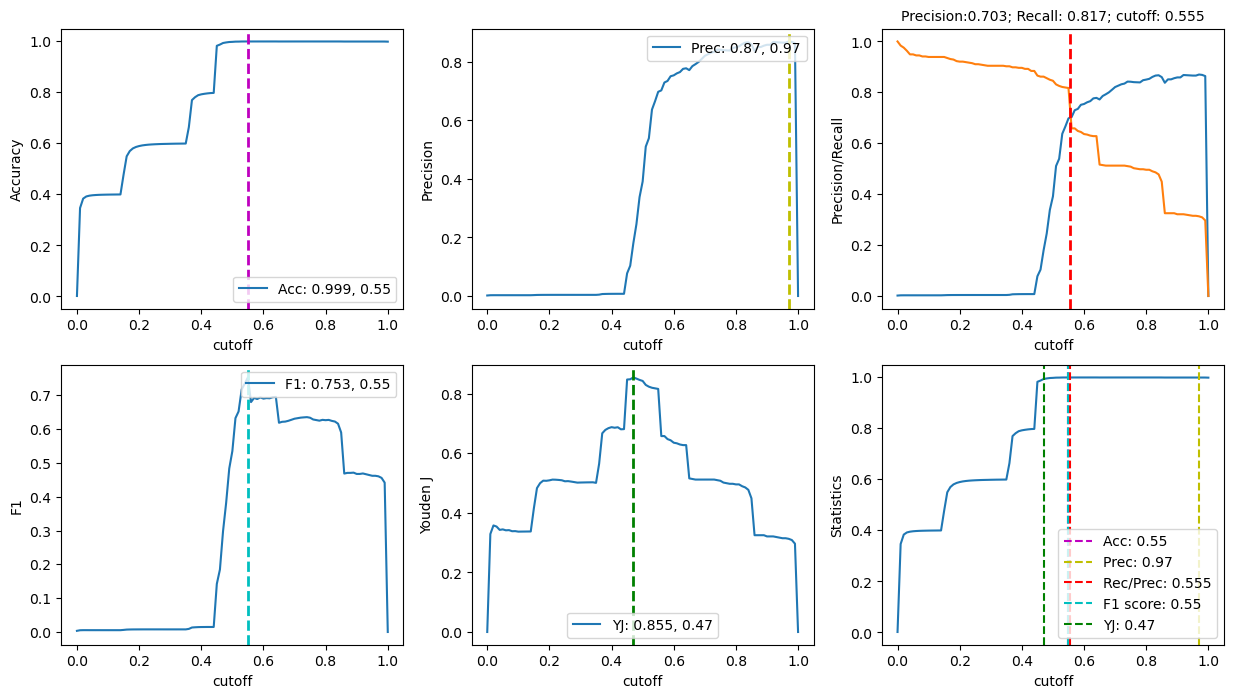

In [52]:
summarise_model(true, pred)

In [53]:
crosstable(pred, 0.55)

Accuracy: 0.9991
Sensitivity: 0.8171
Precision: 0.6979
F1: 0.7528


Predicted,1,0
Observed,,
1,402,90
0,174,284141


In [54]:
crosstable(pred, 0.47)

Accuracy: 0.993
Sensitivity: 0.8618
Precision: 0.1801
F1: 0.298


Predicted,1,0
Observed,,
1,424,68
0,1930,282385


In [55]:
crosstable(pred, 0.45)

Accuracy: 0.982
Sensitivity: 0.8659
Precision: 0.0775
F1: 0.1422


Predicted,1,0
Observed,,
1,426,66
0,5073,279242


Predicted                                                        
             count    mean     std     min     25%     50%     75%     max
Observed                                                                  
0.0       284315.0  0.1982  0.1818  0.0038  0.0062  0.1523  0.3641  0.9959
1.0          492.0  0.7103  0.2771  0.0044  0.5571  0.7719  0.9947  0.9959

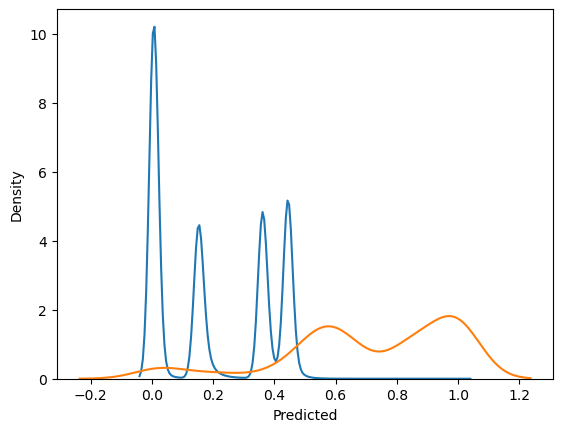

In [56]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe().round(4))

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted")
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted");

Oprócz losowania prostego dostępne są różne metody zaawansowane. Dwie z nich omawiamy poniżej.

### Więcej informacji:

* https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/

# 3. NearMiss/Tomek Link

## 3.1 Tomek Link

Przyjrzyjmy się algorytmowi Tomek link. Polega ono na znalezieniu dla każdej obserwacji z mniejszościowej klasy jego najbliższego sąsiada z przeciwnej klasy i odlosowywanie go ze zbioru. W ten sposób poprawiamy proporcje rozkładu klas, ale również zwiększamy (potencjalnie) separowalność pomiędzy klasami. Przy czym, żeby obserwacje mogły być sparowane, muszą być dla siebie nawzajem najbliższymi sąsiadami.

<img src="img/tomek_link.png" width="40%">
Źródło: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [57]:
def CVTestXGB_tl(nFolds = 5, randomState=2020, features=None, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    
    # Przygotowanie obiektu do undersamplingu
    tl = TomekLinks(n_jobs=-1)

    for train, test in kf.split(df.index.values):
        print(fold)
        # Under sampling zbioru treningowego 
        x_tl, y_tl = tl.fit_resample(df.iloc[train][features], df.iloc[train][target])
        df_tl = pd.concat([x_tl, y_tl], axis=1)
        
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_tl, df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df_tl[target], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [58]:
trainResults, testResults, predictions, indices, hists = CVTestXGB_tl(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

1
2
3
4
5


(0.9352246073704331, 0.9413453526374393)

In [59]:
modelXGB_TL = {
    "name":"XGB TL",
    "description":"Model XGB z Tomek Link",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [60]:
with open("XGB_TL.p", "wb") as fp:
    pickle.dump(modelXGB_TL, fp)

In [61]:
with open("XGB_TL.p", "rb") as fp:
    modelXGB_TL = pickle.load(fp)

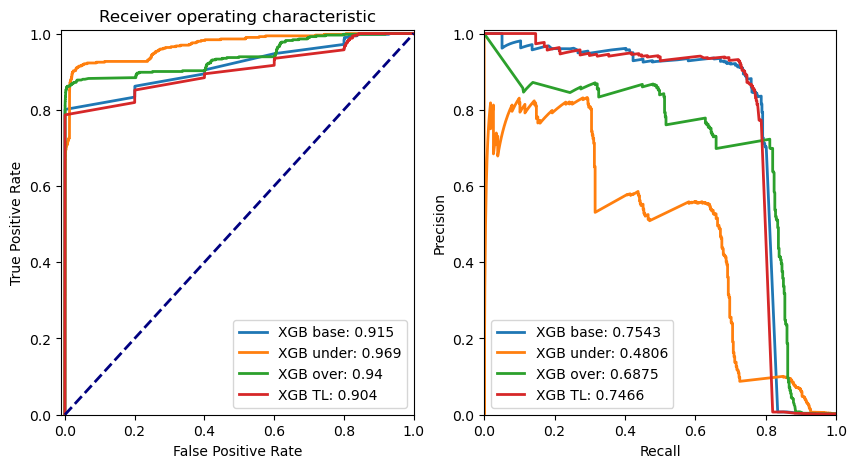

In [62]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelXGB_over, modelXGB_TL]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

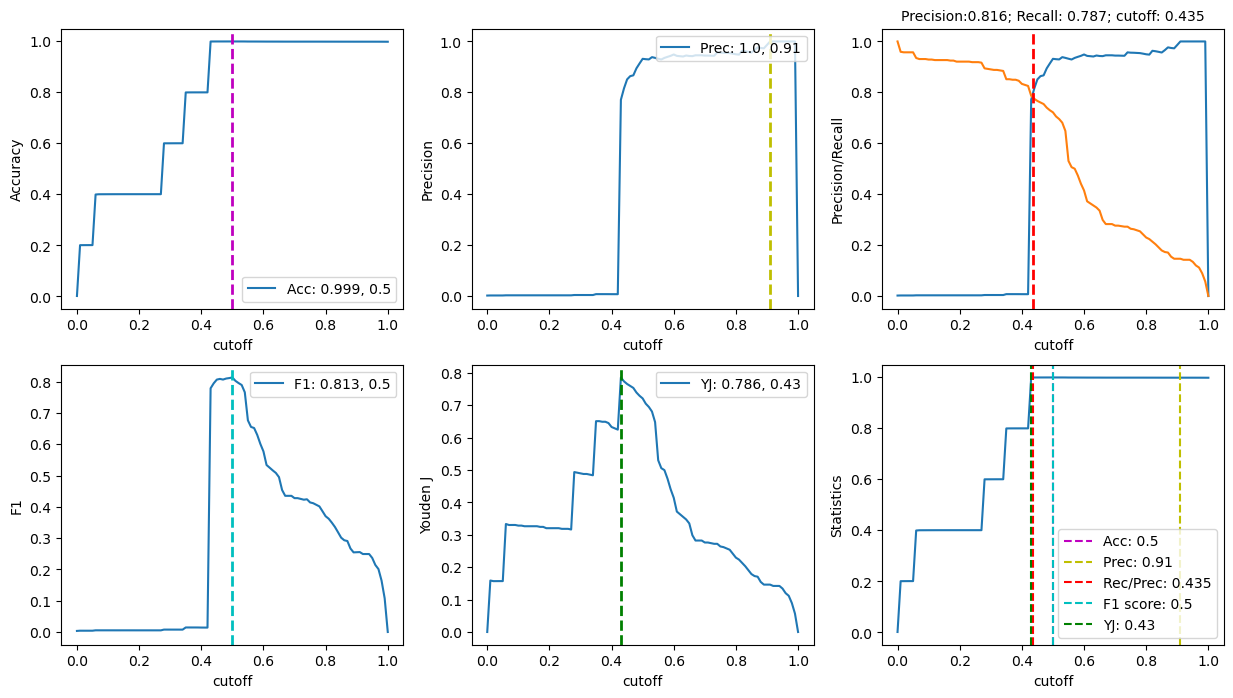

In [63]:
summarise_model(true, pred)

In [64]:
crosstable(pred, 0.43)

Accuracy: 0.9992
Sensitivity: 0.7866
Precision: 0.7709
F1: 0.7787


Predicted,1,0
Observed,,
1,387,105
0,115,284200


In [65]:
crosstable(pred, 0.5)

Accuracy: 0.9994
Sensitivity: 0.7215
Precision: 0.9318
F1: 0.8133


Predicted,1,0
Observed,,
1,355,137
0,26,284289


In [66]:
crosstable(pred, 0.91)

Accuracy: 0.9985
Sensitivity: 0.1463
Precision: 1.0
F1: 0.2553


Predicted,1,0
Observed,,
1,72,420
0,0,284315


Predicted                                                          \
             count    mean     std     min     10%     20%     30%     40%   
Observed                                                                     
0.0       284315.0  0.2221  0.1657  0.0000  0.0001  0.0592  0.0592  0.2731   
1.0          492.0  0.5891  0.2509  0.0001  0.2731  0.4296  0.5160  0.5463   

                                                          
             50%     60%     70%     80%     90%     max  
Observed                                                  
0.0       0.2731  0.3476  0.3476  0.4296  0.4296  0.9068  
1.0       0.5672  0.6039  0.6599  0.8354  0.9742  0.9976

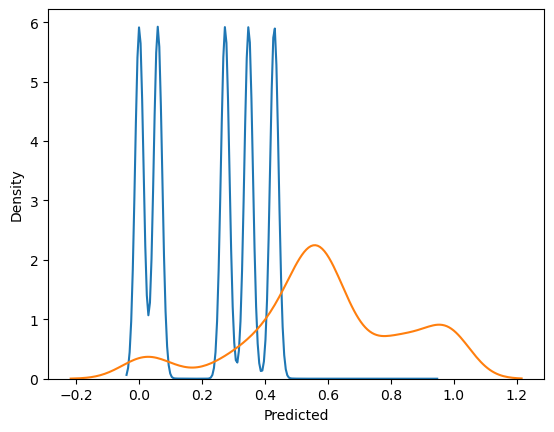

In [67]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe(percentiles=np.arange(1,10, 1)/10).round(4))

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted")
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted");

## 3.2 NearMiss

Algorytm jest podobnie jak Tomek Link wariantem undersamplingu, ale działa w nieco innych sposób:

1. Najpierw liczone są dystanse pomiędzy wszystkimi punktami w klasie większościowej a punktami w klasie mniejszościowej. 
2. Następnie wyznaczane jest n najbliższych sąsiadów każdej z obserwacji z klasy mniejszościowej. Wyznaczenie może nastąpić na jeden z trzech sposobów:
    * NearMiss – Version 1 : It selects samples of the majority class for which average distances to the k closest instances of the minority class is smallest.
    * NearMiss – Version 2 : It selects samples of the majority class for which average distances to the k farthest instances of the minority class is smallest.
    * NearMiss – Version 3 : It works in 2 steps. Firstly, for each minority class instance, their M nearest-neighbors will be stored. Then finally, the majority class instances are selected for which the average distance to the N nearest-neighbors is the largest.
    

### Więcej informacji:
* https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
* https://analyticsindiamag.com/using-near-miss-algorithm-for-imbalanced-datasets/
* https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

In [68]:
def CVTestXGB_nm(nFolds = 5, randomState=2020, features=None, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    
    # Przygotowanie obiektu do undersamplingu
    nm = NearMiss()

    for train, test in kf.split(df.index.values):
        # Under sampling zbioru treningowego 
        x_nm, y_nm = nm.fit_resample(df.iloc[train][features], df.iloc[train][target])
        df_nm = pd.concat([x_nm, y_nm], axis=1)
        
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_nm, df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df_nm[target], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [69]:
trainResults, testResults, predictions, indices, hists = CVTestXGB_nm(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

(0.9950899834196273, 0.9680883246836464)

In [70]:
modelXGB_NM = {
    "name":"XGB NM",
    "description":"Model XGB z NearMiss",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [71]:
with open("XGB_nm.p", "wb") as fp:
    pickle.dump(modelXGB_NM, fp)

In [72]:
with open("XGB_nm.p", "rb") as fp:
    modelXGB_NM = pickle.load(fp)

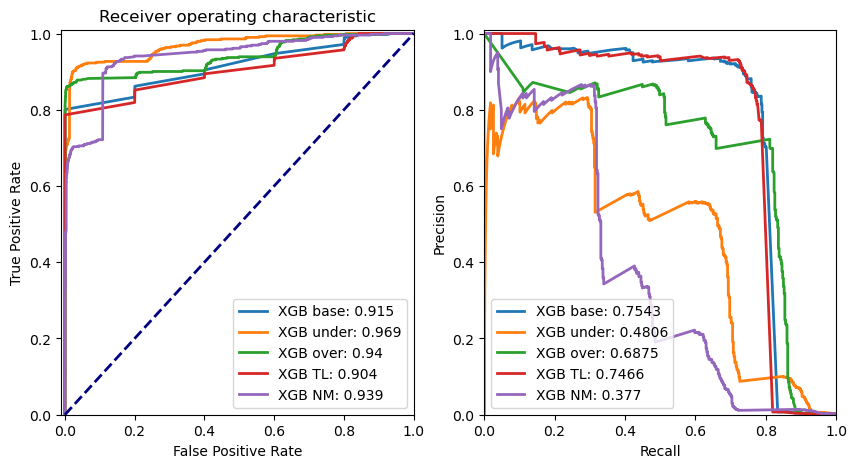

In [73]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelXGB_over, modelXGB_TL, modelXGB_NM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

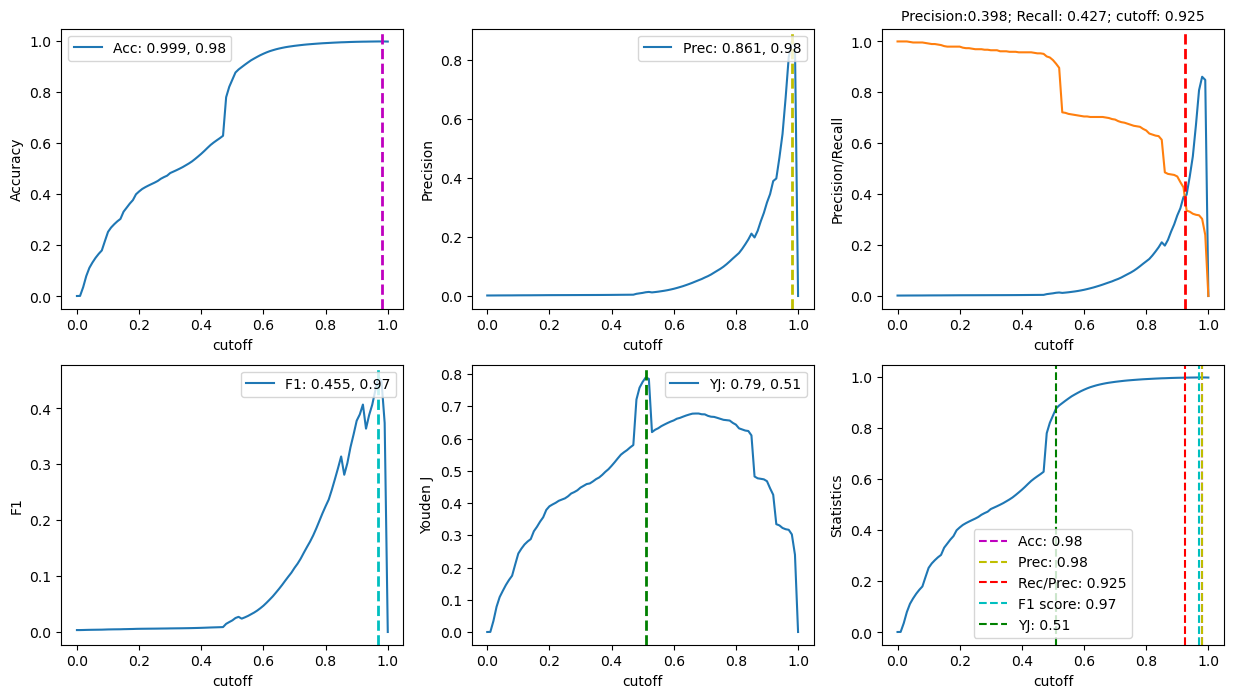

In [74]:
summarise_model(true, pred)

In [75]:
crosstable(pred, 0.51)

Accuracy: 0.8771
Sensitivity: 0.9126
Precision: 0.0127
F1: 0.025


Predicted,1,0
Observed,,
1,449,43
0,34968,249347


In [76]:
crosstable(pred, 0.97)

Accuracy: 0.9987
Sensitivity: 0.3171
Precision: 0.8083
F1: 0.4555


Predicted,1,0
Observed,,
1,156,336
0,37,284278


Predicted                                                        
             count    mean     std     min     25%     50%     75%     max
Observed                                                                  
0.0       284315.0  0.3077  0.2053  0.0085  0.0993  0.3310  0.4778  0.9941
1.0          492.0  0.7881  0.2251  0.0319  0.5229  0.8569  0.9890  0.9943

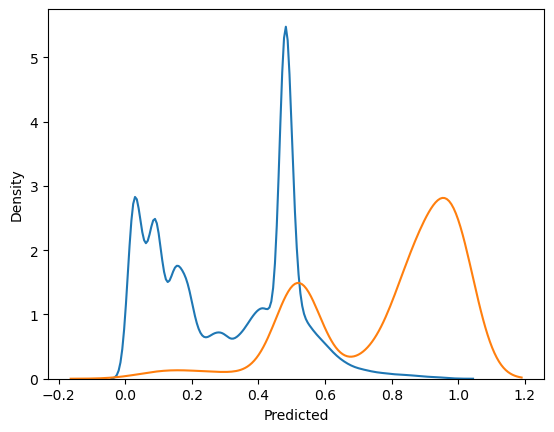

In [77]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe().round(4))

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted")
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted");

# 4. Metody zaawansowane: ROSE/SMOTE

Alternatywą dla undersamplingu są techniki syntetycznego tworzenia obserwacji. Różnice z algorytmami klasycznymi dobrze podsumowuje poniższy rysunek (na przykładzie oversamplingu):

<img src="img/oversampling.png" width=100%>

## 4.1 SMOTE

Zacznijmy od algorytmu SMOTE, który wykorzystuje metodę k najbliższych sąsiadów i Bootstrap. SMOTE ma kilka wariantów. Jeden opisany jest na rysunku, drugi poniżej: 

* znajdź dla każdego punktu z mniejszościowej klasy najbliższego sąsiada,
* policz różnice pomiędzy nimi na wszystkich zmiennych,
* pomnóż różnicę na każdym wymiarze przez losowo wybraną liczbę z rozkładu U(0,1)
* dodaj do wybranej obserwacji – co stworzy nowy punkt pomiędzy wybranymi obserwacjami.

<img src="img/smote.png" width=100%>
Źródło: https://www.svds.com/learning-imbalanced-classes/

In [86]:
def CVTestXGB_SMOTE(nFolds = 5, randomState=2020, features=None, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    
    # Przygotowanie obiektu do undersamplingu
    smote = SMOTE()

    for train, test in kf.split(df.index.values):
        print(fold)
        # Under sampling zbioru treningowego 
        x_smote, y_smote = smote.fit_resample(df.iloc[train][features], df.iloc[train][target])
        df_smote = pd.concat([x_smote, y_smote], axis=1)
        
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df_smote, df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df_smote[target], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [87]:
trainResults, testResults, predictions, indices, hists = CVTestXGB_SMOTE(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

1
2
3
4
5


(0.9992871271978482, 0.9860800446207765)

In [88]:
modelXGB_SM = {
    "name":"XGB Smote",
    "description":"Model XGB z Smote",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [89]:
with open("XGB_sm.p", "wb") as fp:
    pickle.dump(modelXGB_SM, fp)

In [90]:
with open("XGB_sm.p", "rb") as fp:
    modelXGB_SM = pickle.load(fp)

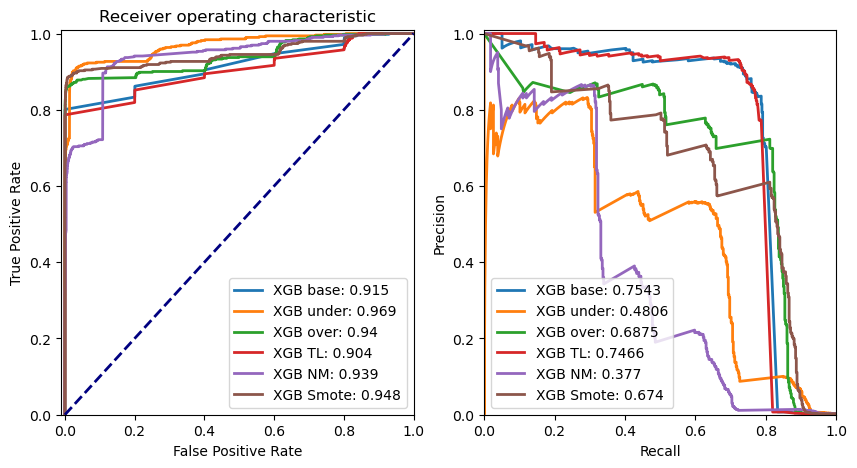

In [91]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelXGB_over, modelXGB_TL, modelXGB_NM, modelXGB_SM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

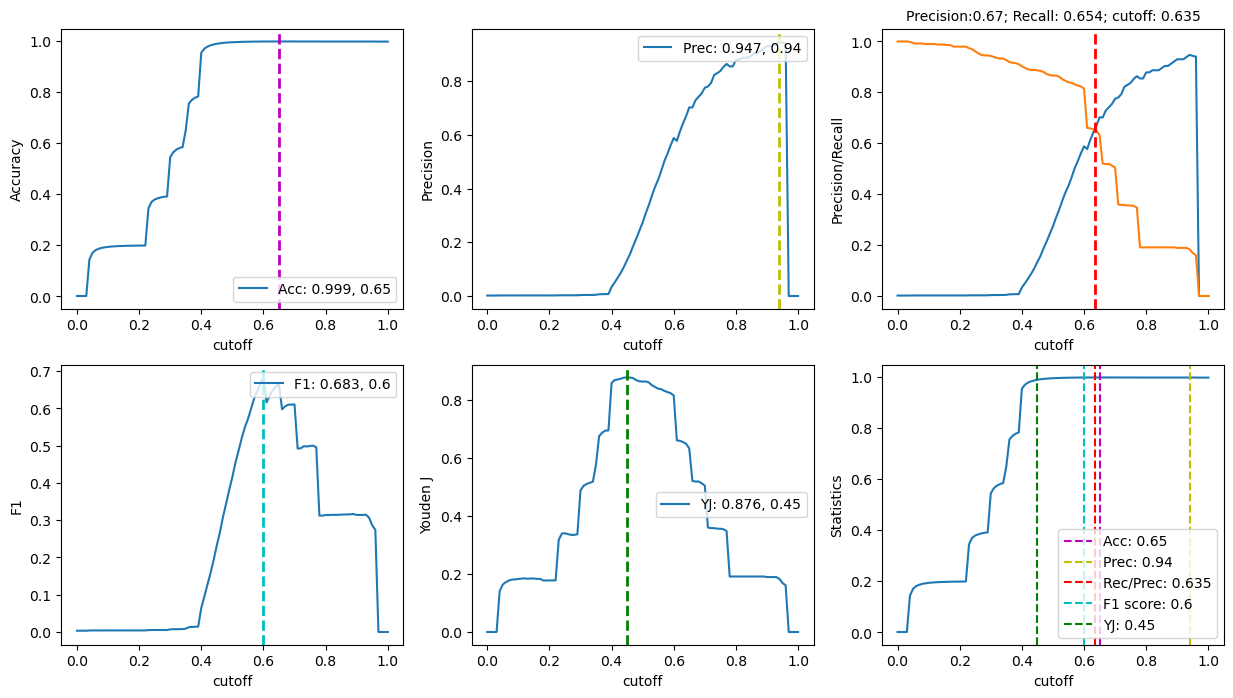

In [92]:
summarise_model(true, pred)

In [93]:
crosstable(pred, 0.63)

Accuracy: 0.9988
Sensitivity: 0.6545
Precision: 0.6427
F1: 0.6485


Predicted,1,0
Observed,,
1,322,170
0,179,284136


In [94]:
crosstable(pred, 0.5)

Accuracy: 0.9958
Sensitivity: 0.8659
Precision: 0.2736
F1: 0.4158


Predicted,1,0
Observed,,
1,426,66
0,1131,283184


In [95]:
crosstable(pred, 0.49)

Accuracy: 0.9951
Sensitivity: 0.8679
Precision: 0.2447
F1: 0.3818


Predicted,1,0
Observed,,
1,427,65
0,1318,282997


Predicted                                                        
             count    mean     std     min     25%     50%     75%     max
Observed                                                                  
0.0       284315.0  0.2679  0.1279  0.0309  0.2233  0.2945  0.3580  0.9699
1.0          492.0  0.6841  0.1974  0.0383  0.6075  0.7083  0.7784  0.9699

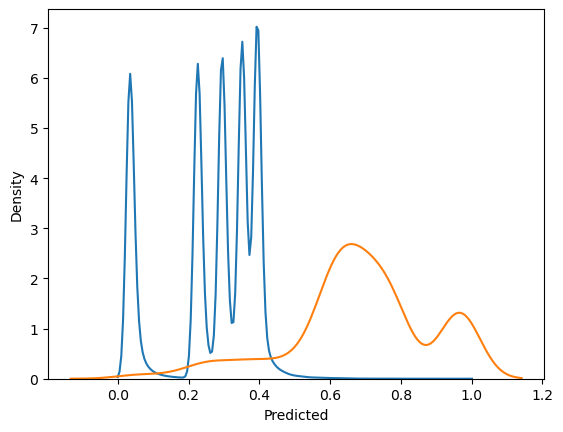

In [96]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe().round(4))

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted")
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted");

### Więcej informacji:
* https://imbalanced-learn.org/stable/over_sampling.html

## 4.2. ROSE

Twórcy algorytmu ROSE zwracają uwagę, że tworzenie syntetycznych obserwacji jest dobrym pomysłem, ponieważ zapobiega przetrenowaniu modelu. W odróżnieniu od SMOTE, algorytm ROSE tworzy nowe obserwacje przez wylosowanie nowych obserwacji z danej klasy (𝑦_𝑖) przez oszacowanie wielowymiarowego rozkładu normalnego o wycentrowanego w losowym punkcie $(𝑥_𝑖,𝑦_𝑖)$ z danej klasy i macierzy wariancji-kowariancji 𝐻_𝑖 (tzw. Smoothing matrix).

<img src="img/rose.png" width="30%">
Źródło: https://www.svds.com/learning-imbalanced-classes/

### Więcej informacji:
* https://imbalanced-learn.org/stable/over_sampling.html
* https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler

In [97]:
# (szacowanie długo trwa)
trainResults, testResults, predictions, indices, hists = CVTestXGB_over(features=features, max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False, shrinkage=1)
np.mean(trainResults), np.mean(testResults)

(0.999719498903081, 0.9717757915705036)

In [98]:
modelXGB_ROSE = {
    "name":"XGB ROSE",
    "description":"Model XGB z ROSE (shrinkage=1)",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [99]:
with open("XGB_ROSE.p", "wb") as fp:
    pickle.dump(modelXGB_ROSE, fp)

In [100]:
with open("XGB_ROSE.p", "rb") as fp:
    modelXGB_ROSE = pickle.load(fp)

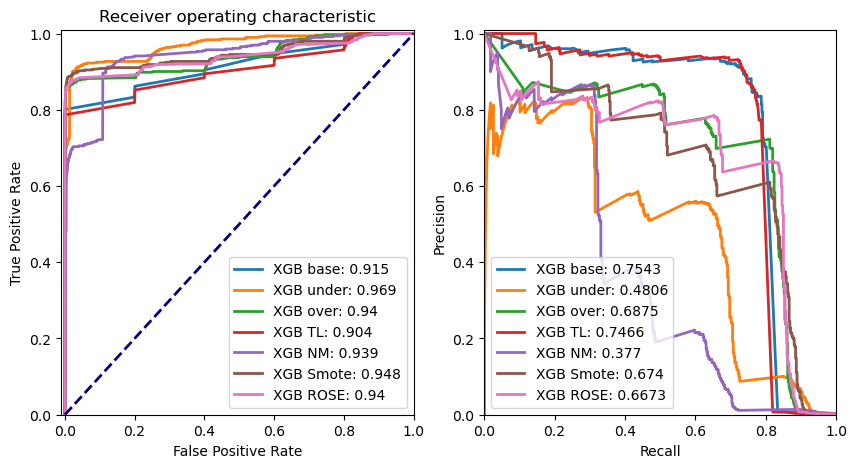

In [101]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelXGB_over, modelXGB_TL, modelXGB_NM, modelXGB_SM, modelXGB_ROSE]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

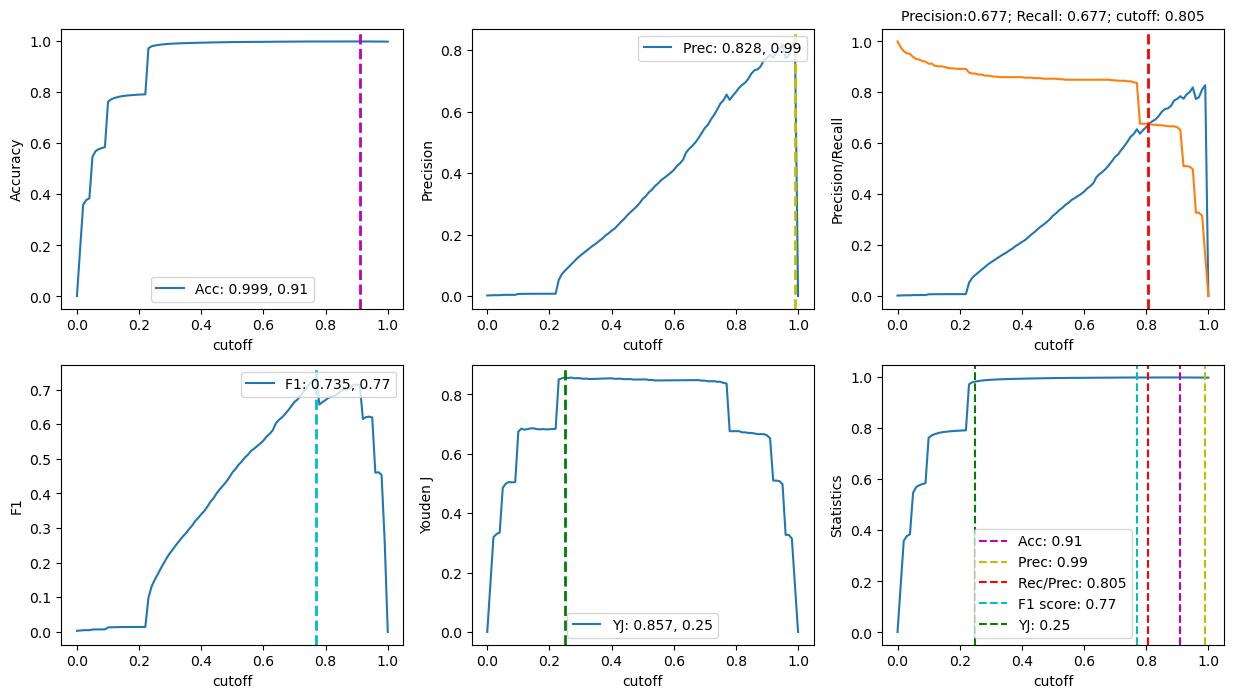

In [102]:
summarise_model(true, pred)

In [103]:
crosstable(pred, 0.77)

Accuracy: 0.999
Sensitivity: 0.8374
Precision: 0.655
F1: 0.7351


Predicted,1,0
Observed,,
1,412,80
0,217,284098


In [104]:
crosstable(pred, 0.25)

Accuracy: 0.983
Sensitivity: 0.874
Precision: 0.0824
F1: 0.1506


Predicted,1,0
Observed,,
1,430,62
0,4790,279525


Predicted                                                        
             count    mean     std     min     25%     50%     75%     max
Observed                                                                  
0.0       284315.0  0.0849  0.0908  0.0039  0.0170  0.0494  0.0933  0.9964
1.0          492.0  0.8020  0.2982  0.0044  0.7782  0.9496  0.9840  0.9964

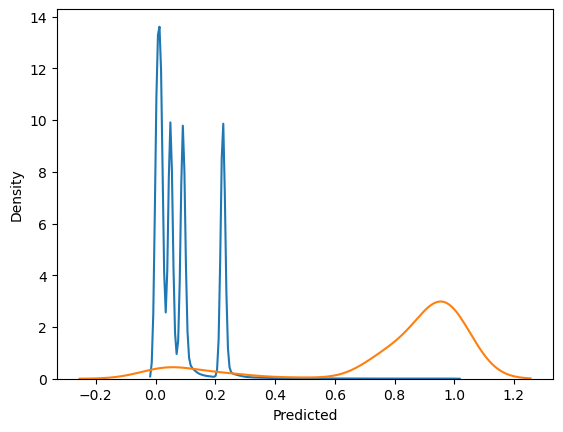

In [105]:
data = pd.DataFrame([true, pred]).transpose()
display(data.groupby('Observed').describe().round(4))

sn.kdeplot(data=data.loc[data.Observed==0], x="Predicted")
sn.kdeplot(data=data.loc[data.Observed==1], x="Predicted");

### Więcej informacji:
* https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_shrinkage_effect.html#sphx-glr-auto-examples-over-sampling-plot-shrinkage-effect-py

# 5. Modele z modyfikowalną funkcją celu

W wielu algorytmach istnieje możliwość dobierania innych wag dla każdej z klas w funkcji kary – można to rozumieć jako zwiększanie znaczenia klasy w naszej funkcji zysku. Ponieważ wagi są ustalane arbitralnie przez analityka, zwykle dokonujemy ich tuningu w procesie walidacji krzyżowej.

Więcej źródeł:
* https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/

## 5.1 Modyfikacja funkcji celu w regresji logistycznej

Zacznijmy od sprawdzenia, jak radzi sobie zwykła regresja logistyczna.

In [106]:
from sklearn.linear_model import LogisticRegression

In [107]:
def CVTestLogit(nFolds = 5, randomState=2020, *args, **kwargs):
    # Podzielenie zbioru na foldy
    kf = KFold(n_splits = nFolds, shuffle=True, random_state=randomState)
    # Losty na wyniki
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    k=1
    # Pętla do estymacji i walidacji modeli na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Stworzenie modelu
        lr = LogisticRegression(*args, **kwargs)
        # Estymacja
        lr.fit(df.iloc[train][features], df.iloc[train][target])
        # Zapisanie predykcji
        predsTrain = lr.predict_proba(df[features].iloc[train])[:,1]
        predsTest = lr.predict_proba(df[features].iloc[test])[:,1]
        # Zapisanie wyników ze zbioru walidacyjnego do listy
        trainResults.append(roc_auc_score(df[target].iloc[train], predsTrain))
        testResults.append(roc_auc_score(df[target].iloc[test], predsTest))
         # Zachowajmy informacje o predykcjach dla tego foldu i ich indeksach
        predictions.append(predsTest.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())
    # Zwracamy średnią z wyników train i test oraz różnicę (przetrenowanie)
    return trainResults, testResults, predictions, indices

In [108]:
trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, max_iter=5000)
np.mean(trainResults), np.mean(testResults)

(0.94445116492763, 0.9438257834415108)

In [109]:
modelLogit = {
    "name":"Logit",
    "description":"Zwykła regresja bez modyfikacji funkcji straty",
    "specification":'solver="newton-cg", penalty=None',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [110]:
trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, class_weight='balanced', max_iter=5000)
np.mean(trainResults), np.mean(testResults)

(0.9754789765513813, 0.9715588175911078)

In [111]:
modelBalanced = {
    "name":"Logit Balanced",
    "description":"Zwykła regresja z modyfikacją wag na zbalansowane",
    "specification":'solver="newton-cg", penalty=None, weight="balanced"',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [112]:
for w in np.linspace(0.0,0.99,20):
    trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, class_weight={0:1-w, 1:w}, max_iter=5000)
    print(w, np.mean(trainResults), np.mean(testResults))

0.0 0.4989508424618755 0.4990125475634116
0.05210526315789474 0.8778947681038016 0.8755553054358426
0.10421052631578948 0.8847757645565434 0.8825548563937806
0.1563157894736842 0.9041174893686547 0.9041575877157019
0.20842105263157895 0.9123406569649521 0.9066592283114459
0.2605263157894737 0.9260399684796748 0.9242263846283192
0.3126315789473684 0.9357118734247427 0.9329662833373471
0.36473684210526314 0.9375932597044432 0.9386171342813494
0.4168421052631579 0.9391753940290185 0.9393087731838892
0.46894736842105267 0.94558099610511 0.9434497901764483
0.5210526315789474 0.9481519871541266 0.946026927470119
0.5731578947368421 0.9423072223392162 0.9417303966606292
0.6252631578947369 0.9420209780200242 0.9438216613278728
0.6773684210526316 0.9544728671603728 0.9526142803345676
0.7294736842105263 0.9468287628116316 0.948363737220063
0.781578947368421 0.9519140932398429 0.9513981313341844
0.8336842105263158 0.9540457915470117 0.9508306824109148
0.8857894736842106 0.9491169260212924 0.949225

In [113]:
for w in [.95, .97, .99, .995, .999]:
    trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, class_weight={0:1-w, 1:w}, max_iter=5000)
    print(w, np.mean(trainResults), np.mean(testResults))

0.95 0.9667452697038768 0.9636532688839978
0.97 0.9699120804610365 0.9637443604066401
0.99 0.9731548717126991 0.971956961510657
0.995 0.9680383402582944 0.960866043628201
0.999 0.9647321185806398 0.9635467876054309


In [114]:
for w in [.99, .991, .992, .993]:
    trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, class_weight={0:1-w, 1:w}, max_iter=5000)
    print(w, np.mean(trainResults), np.mean(testResults))

0.99 0.9731548717126991 0.971956961510657
0.991 0.967344481593923 0.9623515119900906
0.992 0.9643540880868651 0.959904769457028
0.993 0.9704635273660582 0.9648852588279212


In [115]:
# Trening finalnego modelu
w=.99

trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, class_weight={0:1-w, 1:w}, max_iter=5000)
np.mean(trainResults), np.mean(testResults)

(0.9731548717126991, 0.971956961510657)

In [116]:
modelTuned = {
    "name":"Logit Tuned",
    "description":"Regresja logistyczna z tuningiem macierzy wag",
    "specification":'solver="newton-cg", penalty=None, weight=.99',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

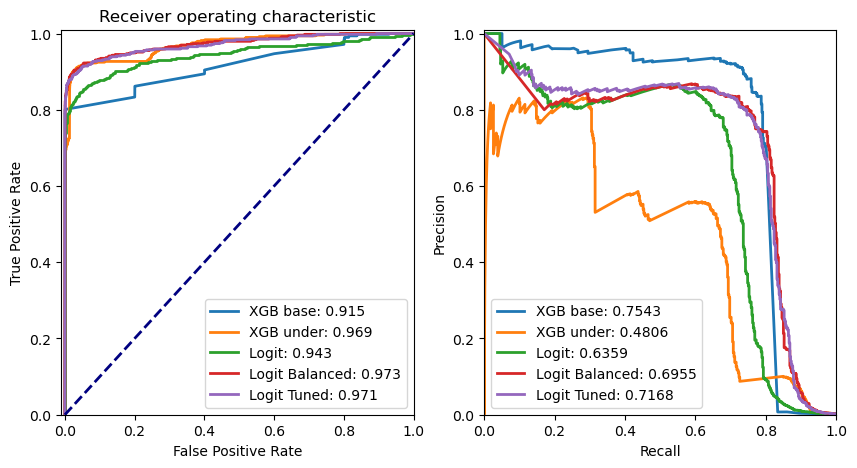

In [117]:
res2plot = []

for result in [modelXGB, modelXGB_under, modelLogit, modelBalanced, modelTuned]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], []), name='Predicted').sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCandPRs(res2plot)

In [118]:
trainResults, testResults, predictions, indices = CVTestLogit(solver='lbfgs', penalty=None, class_weight='balanced', max_iter=5000)
np.mean(trainResults), np.mean(testResults)

(0.9754789765513813, 0.9715588175911078)

In [119]:
pred

0         1.339203e-01
1         4.701064e-01
2         1.707691e-01
3         5.698437e-02
4         1.627348e-01
              ...     
284802    9.826428e-10
284803    5.783233e-05
284804    5.282919e-03
284805    5.022998e-04
284806    3.378495e-03
Name: Predicted, Length: 284807, dtype: float64

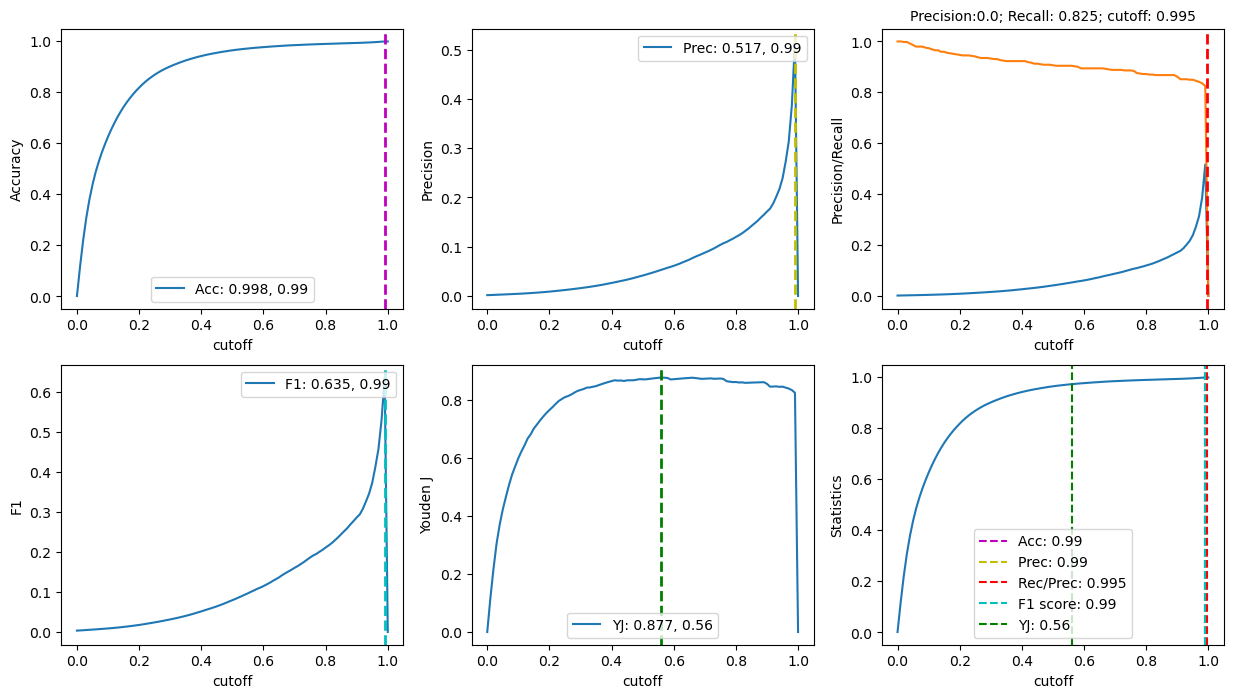

In [120]:
pred = pd.Series(sum(modelBalanced["predictions"], []), index=sum(modelBalanced["indices"], []), name='Predicted').sort_index()

summarise_model(true, pred)

In [121]:
crosstable(pred, 0.56)

Accuracy: 0.972
Sensitivity: 0.9045
Precision: 0.0531
F1: 0.1004


Predicted,1,0
Observed,,
1,445,47
0,7929,276386


Źródło:
* https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

## 5.2 Wykorzystanie wag w modelu SVM

Wbudowany parametr modyfikujący wagi znajduje się również w modelu SVM - ale nie zastosujemy go na tym zbiorze, ponieważ jest za duży dla SVM. Poniżej jedynie próbka kodu:

<img src="img/svm-penalized.png" width="30%">
Źródło: https://www.svds.com/learning-imbalanced-classes/

In [ ]:
# from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
# svc_model = SVC(class_weight='balanced', probability=True)